# Ultralytics Classifier

Set up runtime to use GPU

## Create or get the dataset

In [1]:
# https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads
# Get bottle dataset
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz

--2024-10-16 17:45:39--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155880244 (149M) [application/x-xz]
Saving to: ‘bottle.tar.xz’

bottle.tar.xz       100%[===================>] 148.66M  20.6MB/s    in 8.5s    

2024-10-16 17:45:48 (17.6 MB/s) - ‘bottle.tar.xz’ saved [155880244/155880244]



In [2]:
!tar -xf bottle.tar.xz

In [ ]:
!pip install ultralytics

In [7]:
import os
import shutil
import random
import yaml
# pathlib

def get_filenames(folder):
    filenames = []
    for f in folder:
        for file in os.listdir(f):
            filename = os.path.join(f, file)
            filenames.append(filename)
    return filenames

def split_train_test_val(filenames, train_pct, test_pct, val_pct):
    random.shuffle(filenames)

    # Calculate split indices
    total_files = len(filenames)
    split_train = int(train_pct * total_files)
    split_val = split_train + int(val_pct * total_files)

    # Split filenames
    train_filenames = filenames[:split_train]
    val_filenames = filenames[split_train:split_val]
    test_filenames = filenames[split_val:]
    return train_filenames, val_filenames, test_filenames

if os.path.exists("dataset"):
    shutil.rmtree("dataset")

folder_ok = ["bottle/train/good"]
#folder_nok = ["bottle/test/broken_large","bottle/test/broken_small","bottle/test/contamination"]
folder_broken_large = ["bottle/test/broken_large"]
folder_broken_small = ["bottle/test/broken_small"]
folder_contamination = ["bottle/test/contamination"]

#filenames_nok = get_filenames(folder_nok)
filenames_ok = get_filenames(folder_ok)
filenames_broken_large = get_filenames(folder_broken_large)
filenames_broken_small = get_filenames(folder_broken_small)
filenames_contamination = get_filenames(folder_contamination)

d = {
    "ok": filenames_ok,
    "broken_large": filenames_broken_large,
    "broken_small": filenames_broken_small,
    "contamination": filenames_contamination
}
classes = list(d.keys())
for clas in classes:
    train_filenames, val_filenames, test_filenames = split_train_test_val(d[clas], 0.7,0.2,0.1)
    tasks = ["train", "test","val"]
    for task in tasks:
        folder_dst= f"dataset/{task}/{clas}"
        os.makedirs(folder_dst, exist_ok=True)
        if task == "train":
            for f in train_filenames:
                shutil.copy(f, folder_dst)
        if task == "test":
            for f in test_filenames:
                shutil.copy(f, folder_dst)
        if task == "val":
            for f in val_filenames:
                shutil.copy(f, folder_dst)

dataset = "/content/dataset"
data = {
    "train": f"{dataset}/train",
    "val":   f"{dataset}/val",
    "test":  f"{dataset}/test",
    "nc": len(classes),
    "names": classes,
}
# Create and write to the YAML file
yaml_file_path = f"{dataset}/data.yaml"
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, sort_keys=False)


In [9]:
from ultralytics import YOLO
model = YOLO("yolov8n-cls.pt")
results = model.train(data="/content/dataset", epochs=5, imgsz=224,batch=4, project="/content/dataset/tmp_training")

Ultralytics 8.3.14 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset, epochs=5, time=None, patience=100, batch=4, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/dataset/tmp_training, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /content/dataset/train... 189 images, 0 corrupt: 100%|██████████| 189/189 [00:00<?, ?it/s]
val: Scanning /content/dataset/val... 26 images, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /content/dataset/tmp_training/train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 25.51it/s]

                   all      0.769          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 26.92it/s]


                   all      0.769          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 57.03it/s]

                   all      0.769          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.56it/s]

                   all      0.769          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 37.80it/s]

                   all      0.769          1



5 epochs completed in 0.018 hours.
Optimizer stripped from /content/dataset/tmp_training/train/weights/last.pt, 3.0MB
Optimizer stripped from /content/dataset/tmp_training/train/weights/best.pt, 3.0MB

Validating /content/dataset/tmp_training/train/weights/best.pt...
Ultralytics 8.3.14 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 189 images in 4 classes ✅ 
val: /content/dataset/val... found 26 images in 4 classes ✅ 
test: /content/dataset/test... found 57 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 22.86it/s]


                   all      0.769          1
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/dataset/tmp_training/train


## Inference


In [10]:
import torch
import numpy as np
import cv2
from PIL import Image

class Yolov8Inference:
    def __init__(self, model_path, gpu=False):
        self.model = YOLO(model_path)
        self.device = torch.device("cpu")
        if gpu:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                print(f"Model will run on GPU: {torch.cuda.get_device_name(0)}")
            else:
                print("Model will run on CPU, because GPU is not available")
        else:
            print("Model will run on CPU")
        self.labels = self.model.names

    def predict(self, im):

        # im has to be numpy array
        # start = time.time()
        res = self.model.predict(im, imgsz=640, device=self.device, conf=0.01, iou=0.01, verbose=False)
        # end = time.time()
        # print(f"Model inference: {end-start:2f}s")

        #print(res[0].probs)
        names = res[0].names
        scores = res[0].probs.data.cpu().numpy()

        im_draw = im.copy()
        idx = np.argmax(scores)
        score = scores[idx]
        cv2.putText(im_draw, f"{names[idx]}: {score:.2f}", (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0, 0, 255), 1)

        return im_draw



Model will run on CPU


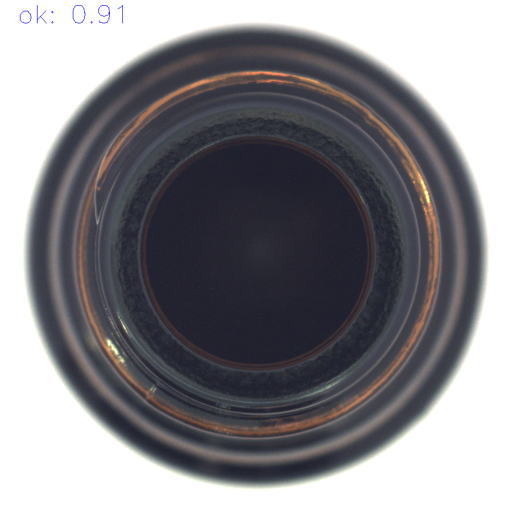

In [12]:
folder_ok = ["bottle/train/good"]
folder_nok = ["bottle/test/broken_large","bottle/test/broken_small","bottle/test/contamination"]
folder_broken_large = ["bottle/test/broken_large"]
folder_broken_small = ["bottle/test/broken_small"]
folder_contamination = ["bottle/test/contamination"]

filenames = get_filenames(folder_ok)

model = Yolov8Inference("/content/dataset/tmp_training/train/weights/best.pt")
for f in filenames:
    im = cv2.imread(f, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_draw = model.predict(im)
    display(Image.fromarray(im_draw).resize((512,512)))
    break